In this notebook we apply feature extraction using data augmentation and Gaussian noise layer. 

Applying additive zero-centered Gaussian noise is useful to mitigate overfitting (you could see it as a form of random data augmentation). Gaussian Noise (GS) is a natural choice as corruption process for real valued inputs (https://keras.io/layers/noise/).

This feature extraction approache extend the `conv_base` model and running it end-to-end on the inputs. Because models behave just like layers, we can add a model (like our `conv_base`) to a `Sequential` model just like we would add a layer.

In [1]:
image_height = 128
image_width = 128
channels = 3
input_shape = (image_height, image_width, channels)

# VGG16

## Feature extraction with data augmentation

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=input_shape)

Using TensorFlow backend.


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Note that different than the previous notebook were we first introduced these models we added a Gaussian noise layer between 2 dense layers (https://machinelearningmastery.com/how-to-improve-deep-learning-model-robustness-by-adding-noise/).

In [5]:
from keras import models
from keras import layers
from keras.layers import GaussianNoise

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(GaussianNoise(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before training the model is necessary to freeze the convolutional base. Otherwise, the weights of conv_base will be updated during training and the representations that were learned by conv_base would get modified during training. Since the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [6]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [7]:
conv_base.trainable = False

In [8]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with a data augmentation configuration:

In [9]:
model.save("../models/VGG16_model_omdena_gaussian_noise_v121119.h5")

In [10]:
import os

def count_files_in_directory(path):
    
    fileslist = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            fileslist.append(filename)
            
    return len(fileslist)

In [11]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

files_train = count_files_in_directory(train_dir)
files_validation = count_files_in_directory(validation_dir)
files_test = count_files_in_directory(test_dir)


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [12]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3]))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, files_train)
validation_features, validation_labels = extract_features(validation_dir, files_validation)
test_features, test_labels = extract_features(test_dir, files_test)

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 128x128
        target_size=(image_height, image_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_height, image_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


In [14]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-12 15:13:18.024840


In [15]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2,
    callbacks=[early_stopping_monitor])

Epoch 1/30
 - 517s - loss: 0.5407 - acc: 0.7655 - val_loss: 0.4355 - val_acc: 0.7611
Epoch 2/30
 - 513s - loss: 0.5306 - acc: 0.7607 - val_loss: 0.6277 - val_acc: 0.7795
Epoch 3/30
 - 505s - loss: 0.5028 - acc: 0.7800 - val_loss: 0.8713 - val_acc: 0.7812
Epoch 4/30
 - 501s - loss: 0.5189 - acc: 0.7690 - val_loss: 0.6781 - val_acc: 0.7896


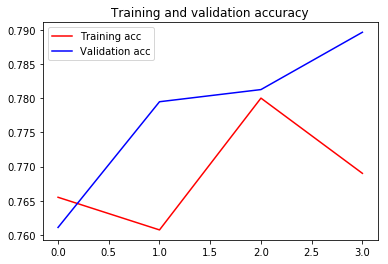

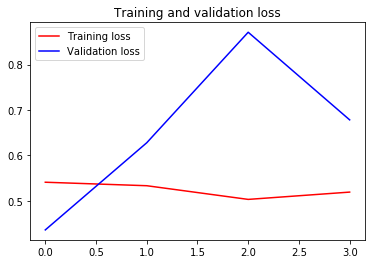

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/VGG_model_omdena_history_gaussian_noise_v111119.csv", index = False)

In [19]:
t2 = datetime.datetime.now()
(print(t2))
print(t2-t1)

2019-11-12 16:13:01.018786
0:59:42.993946


In [1]:
import pandas as pd

df = pd.read_csv("../models/VGG_model_omdena_history_gaussian_noise_v111119.csv")
df.head()

,val_loss,val_acc,loss,acc
0,0.435531,0.761089,0.540651,0.765500
1,0.627670,0.779472,0.532954,0.760727
2,0.871271,0.781250,0.502805,0.780000
3,0.678116,0.789634,0.518896,0.769000


In [3]:
df.iloc[2]

val_loss    0.871271
val_acc     0.781250
loss        0.502805
acc         0.780000
Name: 2, dtype: float64

## adding class_weight = auto

In [20]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history_2 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2,
    callbacks=[early_stopping_monitor],
    class_weight = 'auto')

Epoch 1/30
 - 384s - loss: 0.4924 - acc: 0.7915 - val_loss: 0.3276 - val_acc: 0.7974
Epoch 2/30
 - 389s - loss: 0.5134 - acc: 0.7750 - val_loss: 0.3884 - val_acc: 0.7815
Epoch 3/30
 - 386s - loss: 0.4826 - acc: 0.7956 - val_loss: 0.3428 - val_acc: 0.7762
Epoch 4/30
 - 391s - loss: 0.5160 - acc: 0.7675 - val_loss: 0.7654 - val_acc: 0.7937


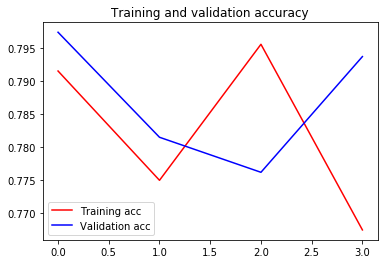

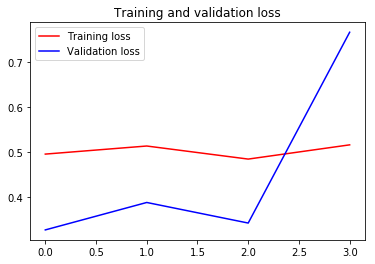

In [21]:
import matplotlib.pyplot as plt

acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

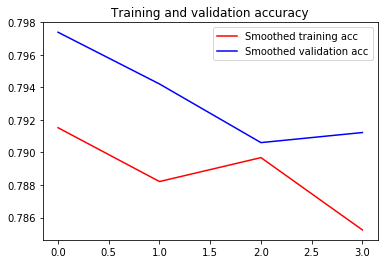

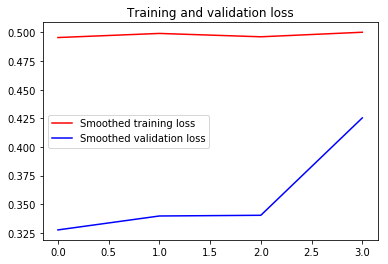

In [23]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history_2.history)

df.to_csv("../models/VGG_model_omdena_history_data_augmentation_weight_auto_gaussian_noise_v111119.csv", index = False)

In [25]:
t3 = datetime.datetime.now()
(print(t3))
print(t3-t2)

2019-11-12 19:38:39.895904
3:25:38.877118


## Fine-tunning

Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [27]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history_3 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor],
      class_weight = 'auto')

Epoch 1/100
100/100 [==============================] - 610s 6s/step - loss: 0.4900 - acc: 0.7970 - val_loss: 0.2569 - val_acc: 0.7933
Epoch 2/100
100/100 [==============================] - 592s 6s/step - loss: 0.4831 - acc: 0.7895 - val_loss: 0.6176 - val_acc: 0.7967
Epoch 3/100
100/100 [==============================] - 593s 6s/step - loss: 0.4764 - acc: 0.7950 - val_loss: 0.6815 - val_acc: 0.7812
Epoch 4/100
100/100 [==============================] - 601s 6s/step - loss: 0.4746 - acc: 0.7875 - val_loss: 0.3877 - val_acc: 0.7967


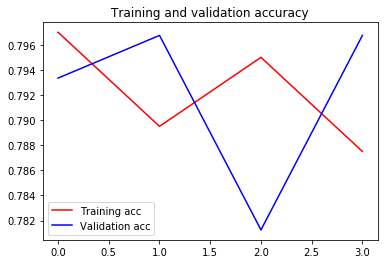

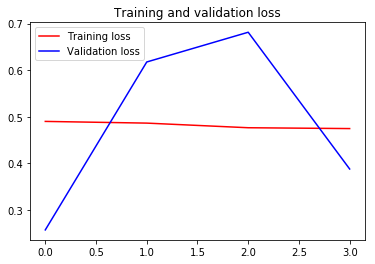

In [29]:
import matplotlib.pyplot as plt

acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

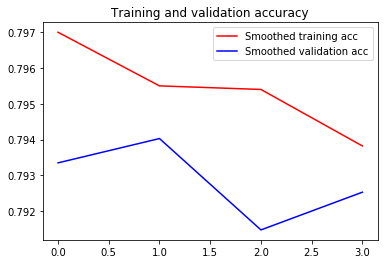

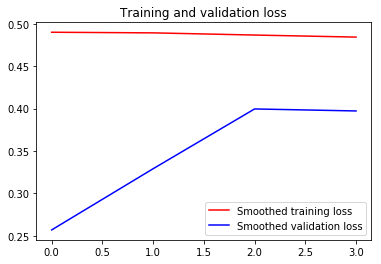

In [32]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history_3.history)

df.to_csv("../models/VGG_model_omdena_history_data_augmentation_weight_auto_fine_tunned_gaussian_noise_v111119.csv", index = False)

In [31]:
t4 = datetime.datetime.now()
(print(t4))
print(t4-t3)

2019-11-12 20:18:50.084135
0:40:10.188231
